# Pipeline analysis for supervised data
Let's start simple by analyzing the data from a single individual, considering: total distance, look-around, sniffing, inner-zone time, wall-climbing, and huddle. We start by importing the necessary packages and directories.

In [64]:
import os
import pandas as pd
import pickle
import deepof.data
import deepof.visuals
import visuals_customized
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Open an existing DeepOF project
directory_output = '//folder/becell/Lab Projects/ERCstG_HighMemory/Data/Marc/1) SOC/2024-01a02 cFos/'
my_deepof_project = deepof.data.load_project(directory_output + "deepof_tutorial_project")

In [4]:
# Open an existing supervised analysis
with open(directory_output + 'supervised_annotation.pkl', 'rb') as file:
    supervised_annotation = pickle.load(file)

In [5]:
# Load conditions
my_deepof_project.load_exp_conditions(directory_output + 'conditions.csv')

In [6]:
# Define colors
white = '#FFFFFF'
grey_soft = '#D3D3D3'
grey_stark = '#636466'
blue = '#194680'
red = '#801946'

### Detect outliers

In [ ]:
# Detect outliers
# Detect outliers
specific_group = 'unpaired'
bin_indexs = [3]
embedding_datasets = []
for bin_index in bin_indexs:
    _, embedding_dataset, _, _ = visuals_customized.plot_embeddings(
        my_deepof_project,
        supervised_annotations=supervised_annotation,
        bin_size=60,
        bin_index=bin_index,
        my_title = '',
        my_color_dict = color_dict,
        my_coords_dict = coords_dict,
        # given_pca = pca # Uncomment to train a new pca
    )
    embedding_dataset = embedding_dataset[embedding_dataset['experimental condition'] == specific_group]
    embedding_dataset = embedding_dataset.drop('experimental condition', axis=1)
    embedding_dataset = embedding_dataset.rename(columns={'PCA-1': 'PCA_1_' + str(bin_index),
                                                          'PCA-2': 'PCA_2_' + str(bin_index)})
    
    embedding_datasets.append(embedding_dataset)
df = pd.concat(embedding_datasets, axis=1)

# Option 1: Using Z-score
from scipy.stats import zscore
z_scores = zscore(df)
abs_z_scores = abs(z_scores)

In [7]:
del supervised_annotation['20240202_Marc_ERC SOC tone_Males_box ab_240003816_02_01_1']

## Plot PCA between conditions

In [72]:
# Define the coordinates for the labels of each condition
coords_dict = {
    'paired': ['Paired', [4,6]],
    'unpaired': ['Unpaired', [4,5]],
    'noshock': ['No-shock', [4,4]],    
    }

In [73]:
# Define the colors for each condition
color_dict = {
    'paired': sns.color_palette("Set1")[0],
    'unpaired': sns.color_palette("Set1")[1],
    'noshock': sns.color_palette("Set1")[2],
    }

In [75]:
ax, embedding_dataset, dataframe_for_titles, pca = visuals_customized.plot_embeddings(
    my_deepof_project,
    supervised_annotations=supervised_annotation,
    bin_size=60,
    bin_index=3,
    my_title = 'PCA tone',
    my_color_dict = color_dict,
    my_coords_dict = coords_dict,
    given_pca = pca # Uncomment to train a new pca
)

TypeError: plot_embeddings() got an unexpected keyword argument 'given_pca'

### Analyze individual PC and rotated_loading_scores

In [ ]:
# Perform statistics
import pingouin as pg
pg.normality(embedding_dataset, 'PCA-2', 'experimental condition')
pg.homoscedasticity(embedding_dataset, 'PCA-2', 'experimental condition')

x = embedding_dataset[embedding_dataset['experimental condition'] == 'hc_ee']['PCA-2']
y = embedding_dataset[embedding_dataset['experimental condition'] == 'hc_ind']['PCA-2']
pg.ttest(x, y).round(3)

# pg.anova(embedding_dataset, 'PCA-1', 'experimental condition')
# pg.pairwise_tukey(embedding_dataset, 'PCA-1', 'experimental condition')

In [ ]:
# Save your statistics in a dictionary
stats_dict = {
    '*': ['hc_ee', 'hc_ind']
    }

In [ ]:
# Plot the PC components
visuals_customized.boxplot(embedding_dataset, color_dict, 'PCA-1', stats_dict)

In [ ]:
# Plot the rotated loading scores of PC components
rotated_loading_scores = pca.components_
visuals_customized.lollipop(dataframe_for_titles, rotated_loading_scores, 'PCA-1')

## Plot PCA between time points

In [68]:
# Define the coordinates for the labels of each condition
coords_dict = {
#    'bin0': ['name1', [4,5]],
    'bin1': ['Before tone', [-4,5]],
#    'bin2': ['Before tone', [-4,5]],
    'bin3': ['During tone', [4,3.5]],
    }

In [69]:
# Define the colors for each condition
color_dict = {
#    'bin0': sns.color_palette("Set1")[0],
    'bin1': grey_stark,
#    'bin2': grey_stark,
    'bin3': blue
    }

In [71]:
ax, embedding_dataset, dataframe_for_titles, concat_hue, pca= visuals_customized.plot_embeddings_timelapse(
    my_deepof_project,
    supervised_annotations=supervised_annotation,
    bin_size=60,
    bin_index_list=[1,3],
    my_title = ' (1-2 vs 3-4 min)',
    my_color_dict = color_dict,
    my_coords_dict = coords_dict,
    specific_condition = 'unpaired',
    given_pca = pca # Uncomment to train a new pca
)

TypeError: plot_embeddings_timelapse() got an unexpected keyword argument 'given_pca'

### Analyze individual PC, rotated_loading_scores (across time) 

In [49]:
# Perform statistics
import pingouin as pg
pg.normality(embedding_dataset, 'PCA-1', 'experimental condition')

,W,pval,normal
experimental condition,,,
bin1,0.918186,0.492395,True
bin3,0.888799,0.311940,True


In [50]:
pg.homoscedasticity(embedding_dataset, 'PCA-1', 'experimental condition')

,W,pval,equal_var
levene,2.429261,0.150148,True


In [51]:
x = embedding_dataset[embedding_dataset['experimental condition'] == 'bin1']['PCA-1']
y = embedding_dataset[embedding_dataset['experimental condition'] == 'bin3']['PCA-1']
pg.ttest(x, y).round(3)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.159,10,two-sided,0.01,"[-4.09, -0.71]",1.824,5.157,0.812


In [ ]:
pg.anova(embedding_dataset, 'PCA-1', 'experimental condition')
pg.pairwise_tukey(embedding_dataset, 'PCA-1', 'experimental condition')

In [52]:
# Save your statistics in a dictionary
stats_dict = {
    #'**': ['bin0', 'bin1'],
    #'***': ['bin0', 'bin2'],
    '**': ['bin1', 'bin3'],
    }

<Axes: ylabel='PCA-1 eigenvalues'>

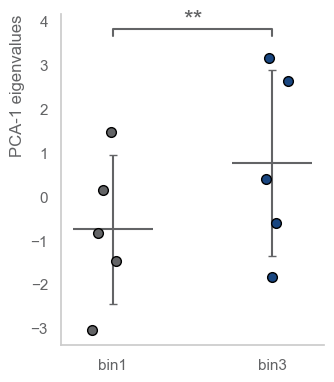

In [57]:
# Plot the PC components
visuals_customized.boxplot(embedding_dataset, color_dict, 'PCA-1', stats_dict)

<Axes: xlabel='PCA-1 rotated loading scores'>

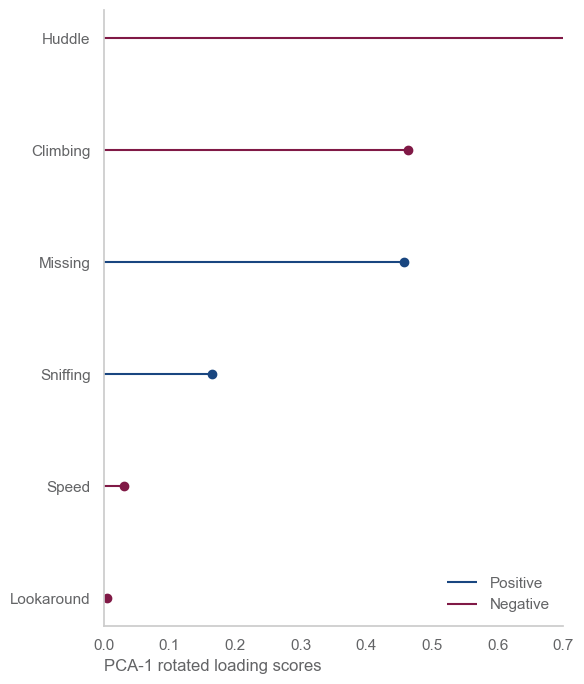

In [58]:
# Plot the rotated loading scores of PC components
rotated_loading_scores = pca.components_
visuals_customized.lollipop(dataframe_for_titles, rotated_loading_scores, 'PCA-1')

<Axes: xlabel='Time bins', ylabel='Huddle'>

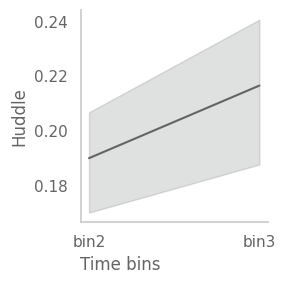

In [24]:
# Plot an individual behavior over bins
visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'huddle')

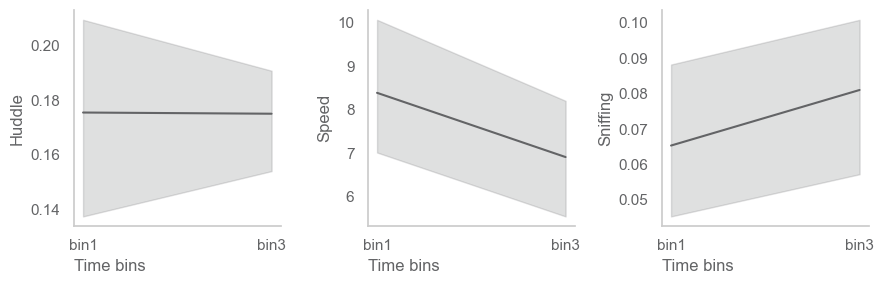

In [59]:
# Plot some individual behaviors over bins
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'huddle', ax=ax1)
visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'speed', ax=ax2)
visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'sniffing', ax=ax3)

# ax1.set_title("supervised embeddings of full videos")
# ax2.set_title("supervised embeddings of first two minutes")

plt.tight_layout()
plt.show()